In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek, to_date, to_timestamp, year, hour, minute, month, when, dayofmonth, dayofweek
from pyspark.sql.functions import concat_ws, lpad, lit
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
from pyspark.sql import functions, types
from pyspark.sql import SparkSession

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = (SparkSession
            .builder
            .master(f'k8s://https://{os.environ["KUBERNETES_SERVICE_HOST"]}:{os.environ["KUBERNETES_SERVICE_PORT"]}')
            .config("spark.kubernetes.container.image", "docker.stackable.tech/demos/pyspark-k8s-with-scikit-learn:3.3.0-stackable23.4")
            .config("spark.driver.port", "2222")
            .config("spark.driver.blockManager.port", "7777")
            .config("spark.driver.host", "driver-service.default.svc.cluster.local")
            .config("spark.driver.bindAddress", "0.0.0.0")
            .config("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
            .config("spark.kubernetes.authenticate.serviceAccountName", "spark")
            .config("spark.executor.instances", "4")
            .config("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
            .appName("taxi-data-anomaly-detection")
            .getOrCreate()
        )

In [3]:
input_df = spark.read.parquet("hdfs://hdfs/ny-taxi-data/raw")

In [4]:
input_df.count()

12106669

In [5]:
df = input_df.select(
        to_date(input_df.pickup_datetime).alias("day_date")
        , year(input_df.pickup_datetime).alias('year')
        , month(input_df.pickup_datetime).alias('month')
        , dayofmonth(input_df.pickup_datetime).alias("dayofmonth")
        , dayofweek(input_df.pickup_datetime).alias("dayofweek")
        , hour(input_df.pickup_datetime).alias("hour")
        , minute(input_df.pickup_datetime).alias("minute")
        , input_df.driver_pay
    )
    
df = df.withColumn("minute_group", when(df.minute < 30, '00').otherwise('30'))
df = df.withColumn("time_group",concat_ws(":", lpad(df.hour, 2, '0'), df.minute_group, lit('00')))
df = df.withColumn("ts",concat_ws(" ", df.day_date, df.time_group))
    
dfs = df.select(
        to_timestamp(df.ts, "yyyy-MM-dd HH:mm:ss").alias("date_group")
        , df.minute_group
        , df.year
        , df.hour
        , df.month
        , df.dayofmonth
        , df.dayofweek
        , df.driver_pay
).groupby("date_group", "minute_group", "hour", "year", "month", "dayofmonth", "dayofweek").agg(functions.count('driver_pay').alias('no_rides'), functions.round(functions.sum('driver_pay'), 2).alias('total_bill'), functions.round(functions.avg('driver_pay'), 2).alias('avg_bill')).orderBy("date_group")

In [6]:

windowSpec  = Window.partitionBy("hour").orderBy("date_group")
    
dfs = dfs.withColumn("lag",lag("no_rides",2).over(windowSpec))
dfs = dfs.filter("lag IS NOT NULL")
    
scaler = StandardScaler()
classifier = IsolationForest(contamination=0.005, n_estimators=200, max_samples=0.7, random_state=42, n_jobs=-1)
    
df_model = dfs.select(dfs.minute_group, dfs.hour, dfs.year, dfs.month, dfs.dayofmonth, dfs.dayofweek, dfs.no_rides, dfs.total_bill, dfs.avg_bill, dfs.lag)
    
x_train = scaler.fit_transform(df_model.collect())
clf = classifier.fit(x_train)
    
SCL = spark.sparkContext.broadcast(scaler)
CLF = spark.sparkContext.broadcast(clf)
    
def predict_using_broadcasts(minute_group, hour, year, month, dayofmonth, dayofweek, no_rides, total_bill, avg_bill, lag):
    prediction = 0
    x_test = [[minute_group, hour, year, month, dayofmonth, dayofweek, no_rides, total_bill, avg_bill, lag]]
    try:
        x_test = SCL.value.transform(x_test)
        prediction = CLF.value.predict(x_test)[0]
    except ValueError:
        import traceback
        traceback.print_exc()
        print('Cannot predict:', x_test)
    return int(prediction)
    
udf_predict_using_broadcasts = functions.udf(predict_using_broadcasts, types.IntegerType())

df_pred = dfs.withColumn(
    'prediction',
    udf_predict_using_broadcasts('minute_group', 'hour', 'year', 'month', 'dayofmonth', 'dayofweek', 'no_rides', 'total_bill', 'avg_bill', 'lag')
)

# map to table columns
df_out = df_pred.select(
    df_pred.date_group.alias("pickup_ts")
    , df_pred.minute_group.alias("pickup_minute_group")
    , df_pred.hour.alias("pickup_hour")
    , df_pred.year.alias("pickup_year")
    , df_pred.month.alias("pickup_month")
    , df_pred.dayofmonth.alias("pickup_dayofmonth")
    , df_pred.dayofweek.alias("pickup_dayofweek")
    , df_pred.no_rides.alias("norides")
    , df_pred.total_bill.alias("total_bill")
    , df_pred.avg_bill.alias("avg_bill")
    , df_pred.lag.alias("norides_lag")
    , df_pred.prediction.alias("pred")
)

In [7]:
df_out.show()

+-------------------+-------------------+-----------+-----------+------------+-----------------+----------------+-------+----------+--------+-----------+----+
|          pickup_ts|pickup_minute_group|pickup_hour|pickup_year|pickup_month|pickup_dayofmonth|pickup_dayofweek|norides|total_bill|avg_bill|norides_lag|pred|
+-------------------+-------------------+-----------+-----------+------------+-----------------+----------------+-------+----------+--------+-----------+----+
|2020-09-02 00:00:00|                 00|          0|       2020|           9|                2|               4|   5196|  69838.45|   13.44|       4794|   1|
|2020-09-02 00:30:00|                 30|          0|       2020|           9|                2|               4|   3818|  51395.77|   13.46|       3600|   1|
|2020-09-03 00:00:00|                 00|          0|       2020|           9|                3|               5|   6113|  79580.45|   13.02|       5196|   1|
|2020-09-03 00:30:00|                 30|     

In [8]:
dfp = df_out.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Let's display this data by plotting some metrics against time.

In [9]:
def plot_metrics(df_line):
    df_outliers = df_line[df_line["pred"]==-1]

    plt.figure(figsize=(24, 4))
    ax1 = plt.subplot()
    plt.plot(df_line.pickup_ts, df_line.norides, linewidth = 1.4)
    plt.plot(df_outliers.pickup_ts, df_outliers.norides, 'o', markersize=12, color='black')
    plt.xlabel('Date')
    plt.ylabel('number of rides',color='b')

    ax2 = ax1.twinx()
    ax2.plot(df_line.pickup_ts, df_line.avg_bill, 'g-', linewidth = 0.9)
    ax2.spines['right'].set_position(('outward', 60))
    plt.ylabel('average bill', color='g')

    ax3 = ax1.twinx()
    ax3.plot(df_line.pickup_ts, df_line.total_bill, 'r-', linewidth = 1.2)
    ax3.spines['right'].set_position(('outward', 120))
    plt.ylabel('total bill', color='r')

    plt.title('Taxi metrics per 30-minute slot')
    plt.show()

First, we will plot three metrics (number of rides, total and average bill) for all time slots. The outliers are marked by the black circles:

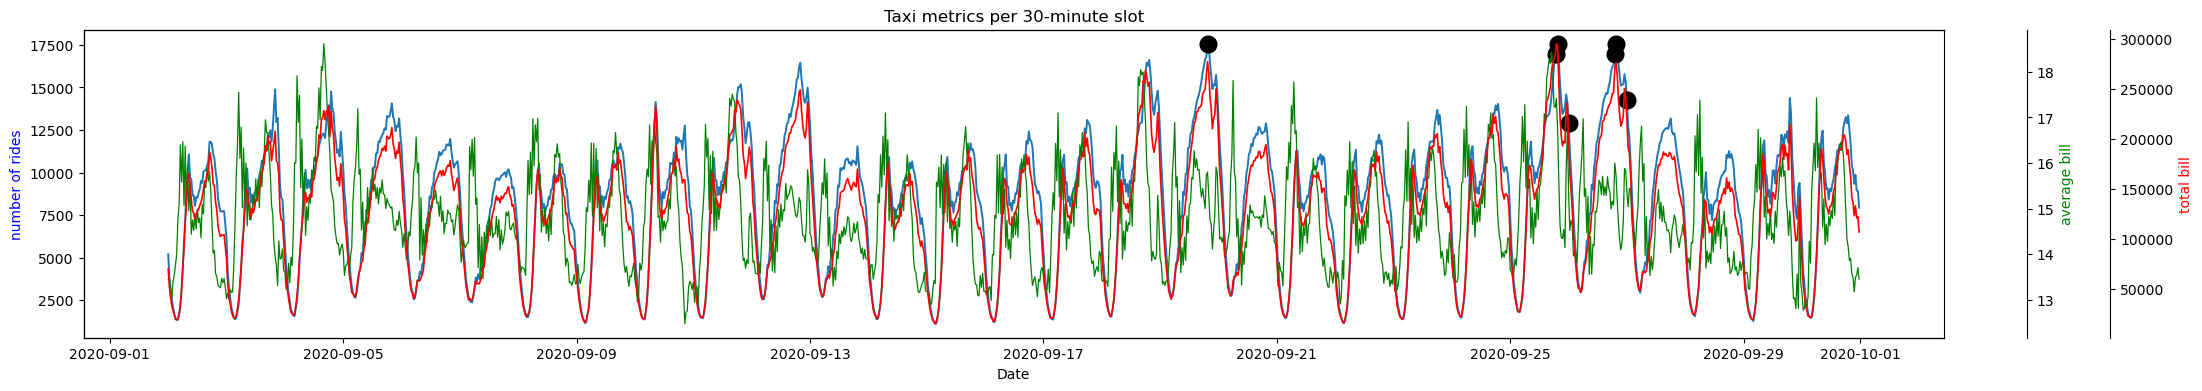

In [10]:
df = dfp.copy()
df.sort_values(by='pickup_ts', inplace=True)
plot_metrics(df)

Let's zoom in on those outliers:

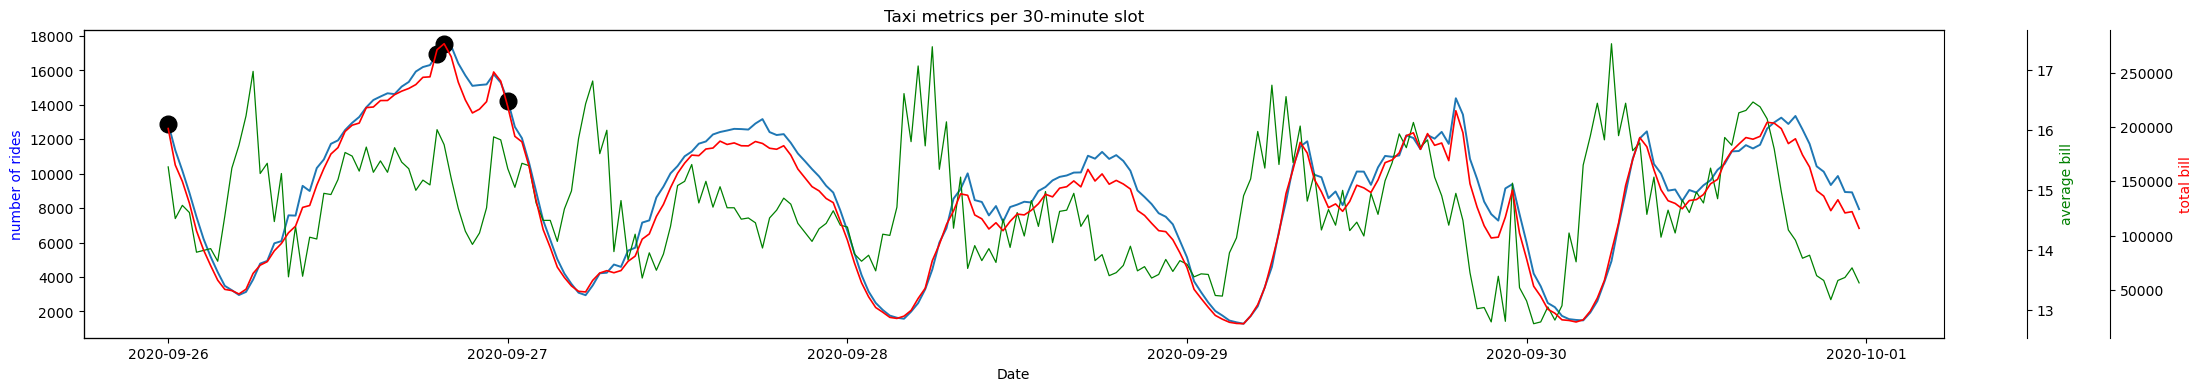

In [11]:
plot_metrics(df[-240:])

The plots above display the outliers mapped onto a particular metric (number of rides), although the anomaly itself is based on all available features. We should really define outliers in terms of the whole feature space, but this is then difficult to visualize due to the *number* of features, each of which is a separate dimension (and this feature set is fairly simple set - some data describing the transaction, different elements of the timestamp, plus one windowed value to add a time-series aspect).

We can visualize the outliers by using a Principle Component Analysis to first reduce these features to a dimensionality that that be plotted. Here is a 3-D representation, that shows the outliers in red:

 1    1385
-1       7
Name: pred, dtype: int64


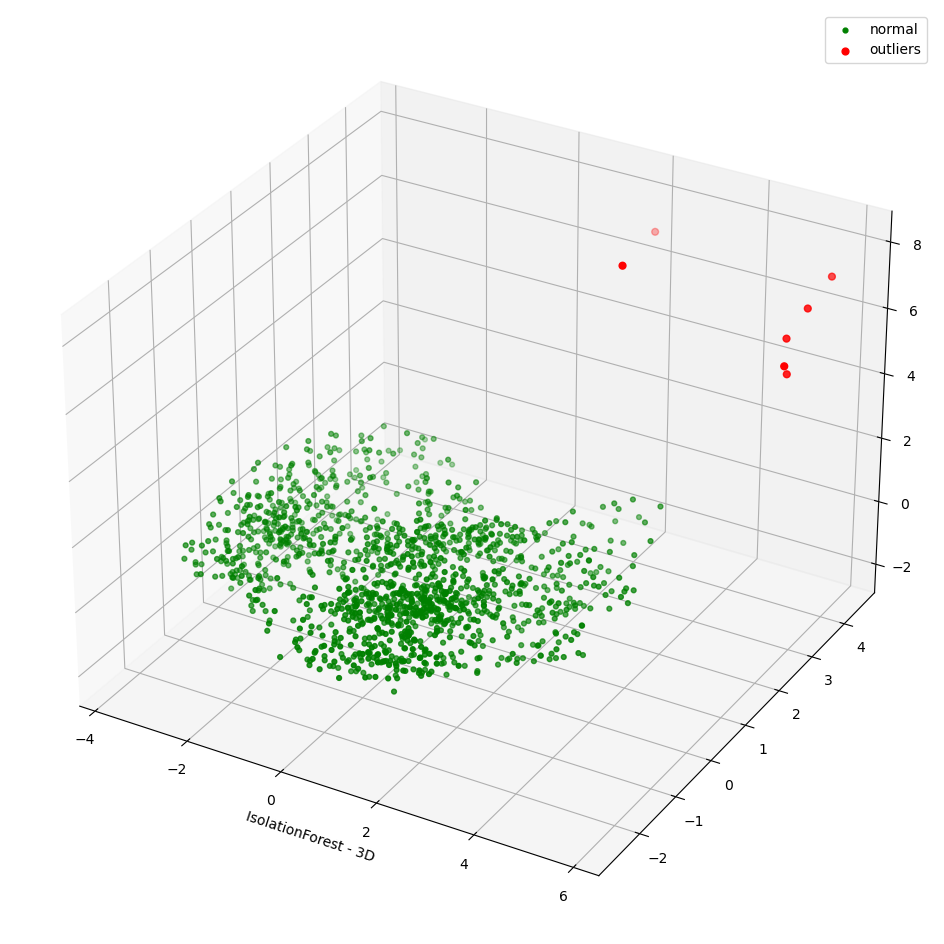

In [12]:
df_pca = dfp.copy()

outliers = df_pca.loc[df_pca['pred']==-1]
outlier_index=list(outliers.index)
inliers = df_pca.loc[df_pca['pred']==1]
inlier_index=list(inliers.index)
print(df_pca['pred'].value_counts())

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

# remove the date column so we can use PCA
dfplt = df_pca.drop(['pickup_ts'], axis=1)

X = scaler.fit_transform(dfplt)
X_reduce = pca.fit_transform(X)

fig = plt.figure(figsize=(12, 12))
_ = ax = fig.add_subplot(111, projection='3d')
_ = ax.set_xlabel("IsolationForest - 3D")

# Plot the compressed data points
_ = ax.scatter(X_reduce[inlier_index, 0], X_reduce[inlier_index, 1], X_reduce[inlier_index, 2], s=12, lw=1, c="green", label="normal")

# Plot ground truth outliers
_ = ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2], s=24, lw=1, c="red", label="outliers")

_ = ax.legend()
plt.show()

We also can do the same with two dimensions:

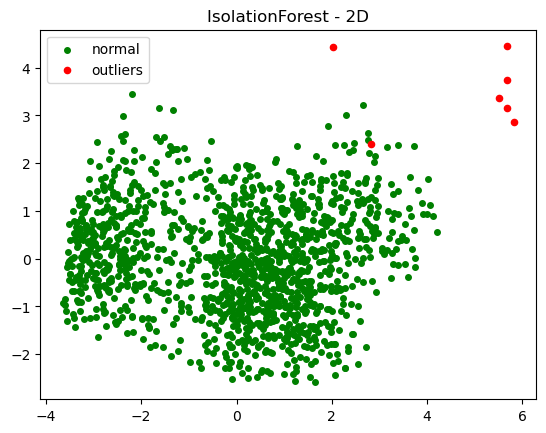

In [13]:
pca = PCA(2) # Reduce to k=2 dimensions
res = pd.DataFrame(pca.fit_transform(X))

_ = plt.title("IsolationForest - 2D")
_ = plt.scatter(res.iloc[inlier_index,0], res.iloc[inlier_index,1], c='green', s=16, label="normal")
_ = plt.scatter(res.iloc[outlier_index,0], res.iloc[outlier_index,1], c='red', s=20, edgecolor="red", label="outliers")
_ = plt.legend()
plt.show();